In [1]:
%matplotlib inline

In [2]:
import os
import time
import matplotlib
# import the necessary packages
from sklearn.metrics import classification_report
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, models, transforms
import torch
from PIL import Image
from simple_model import FirstModel

# cudnn.benchmark = True
plt.ion()   # interactive mode

## Initialize variables

In [3]:
data_dir = '/Users/haroonraja/Google Drive/Colab Notebooks/ConvNetsTransferLearning/data/hymenoptera_data'
batch_size = 32
lr = 0.01
momentum = 0.9
num_epochs = 25

## Select device

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load data



In [5]:
transform = {
            'train': transforms.Compose([transforms.Resize(255),
                                         transforms.RandomRotation(30),
                                         transforms.RandomResizedCrop(224),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.5, 0.5, 0.5],
                                                              [0.5, 0.5, 0.5])]),
            'val': transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor()])
        }
# dataset = datasets.ImageFolder(data_dir, transform=transform['train'])
dataset = {}
dataloader = {}
for x in ['train', 'val']:
    dataset[x] = datasets.ImageFolder(os.path.join(data_dir, x), transform=transform[x])
    dataloader[x] = DataLoader(dataset[x], batch_size=batch_size, shuffle=True)
class_names = dataset['train'].classes

## Displaying a sample image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


(3, 224, 224)


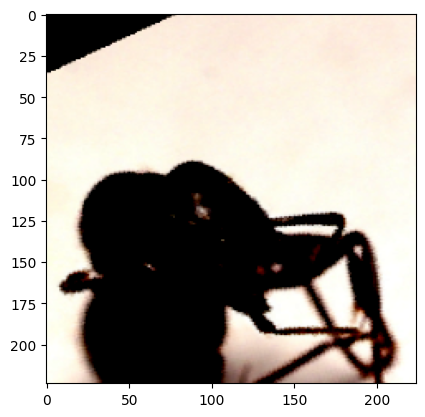

In [6]:
# image = Image.open(dataset['train'][0])
# # image.show()
images, labels = next(iter(dataloader['train']))
fig, ax = plt.subplots()
print(np.shape(images[0].numpy()))
ax.imshow(images[0].numpy().transpose((1, 2, 0)))

# print(dataset['train'][0][0].cpu().detach().numpy())


## Load model

In [7]:
from torchvision.models import resnet18, ResNet18_Weights
# Initialize model
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)


In [8]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Evaluate validation data with Resnet18 pretrained weights

In [48]:
preprocess = weights.transforms()
# Step 3: Apply inference preprocessing transforms
img, _ = next(iter(dataloader['train']))
batch = preprocess(img[0]).unsqueeze(0)

# Step 4: Use the model and print the predicted category
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

bucket: 0.8%


In [61]:
num_params = 0
for param in model.parameters():
    # print(np.shape(param[0]))
    num_params += 1
    # break
print(num_params)

62


## Freezing first 50 layers

In [41]:
num_layer = 0
layers_freeze = 50
for param in model.parameters():
    num_layer += 1
    if num_layer <= layers_freeze:
        param.requires_grad = False
    param.requires_grad = False
print(num_layer)

62


## Change final fully connected layer to number of classes in our dataset

In [42]:
num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)
# model.eval()

## Train model function

In [43]:
def train_model(dataloader, loss_function, model, optimizer, scheduler, num_epochs=5):
    for epoch in range(num_epochs):
        print('Epoch number: {}'.format(epoch))
        for learning_mode in ['train', 'val']:
            if learning_mode == 'train':
                model.train()
            else:
                model.eval()
                
            for i, data in enumerate(dataloader[learning_mode]):
                images, labels = data
                #print(labels[0], np.shape(images))
                optimizer.zero_grad()
                outputs = model(images)
                loss = loss_function(outputs, labels)
                if learning_mode == 'train':
                    loss.backward()
                    optimizer.step()
                # outputs = model(images)
                _, preds = torch.max(outputs, 1)
                print(learning_mode+' loss:', loss.item())
                #print(loss_function(outputs, labels), labels[0], preds)
        
                #imshow(images[0], normalize=False)
        scheduler.step()

## Fine tune using SGD

In [44]:
# # Select loss function
# loss_function = nn.CrossEntropyLoss()
# #loss_function = nn.SoftMarginLoss()


# model = model.to(device)
# # Select Optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# # var1 = 0.1
# # var2 = 0.01
# # optimizer = optim.Adam([var1, var2], lr=0.0001)

# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# train_model(dataloader=dataloader, loss_function=loss_function, model=model, optimizer=optimizer, scheduler=scheduler)

In [ ]:
# optimizer = optim.SGD(model.fc.parameters(), lr=lr, momentum=momentum)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
train_loss = []
val_loss = []
model.to(device)
num_epochs = 2
for epoch in range(num_epochs):
    print('Epoch number: {}'.format(epoch))
    train_loss_curr = []
    val_loss_curr = []
    for learning_mode in ['train', 'val']:
        if learning_mode == 'train':
            model.train()
        else:
            model.eval()

        for i, data in enumerate(dataloader[learning_mode]):
            images, labels = data[0].to(device), data[1].to(device)
            # print(labels[0], np.shape(images))
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            if learning_mode == 'train':
                train_loss_curr.append(loss.item())
            else:
                val_loss_curr.append(loss.item())

            if learning_mode == 'train':
                loss.backward()
                optimizer.step()
            # outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            
            # print(loss_function(outputs, labels), labels[0], preds)

            # imshow(images[0], normalize=False)
    print(f'validation loss: {loss.item():.2f}')
    train_loss.append(np.mean(train_loss_curr))
    val_loss.append(np.mean(val_loss_curr))
    scheduler.step()

## Plot loss

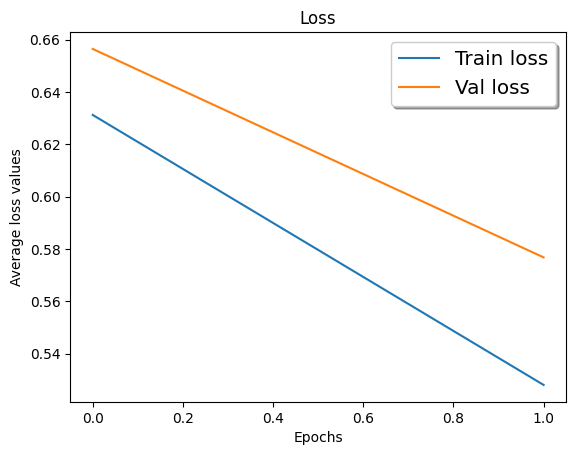

In [93]:
fig, ax = plt.subplots()
ax.plot(train_loss, label='Train loss')
ax.plot(val_loss, label='Val loss')
ax.set(xlabel='Epochs', ylabel='Average loss values',
       title='Loss')
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()
fig.savefig("/Users/haroonraja/Google Drive/Colab Notebooks/ConvNetsTransferLearning/output/test2.pdf")
plt.close(fig)

In [89]:
preprocess = weights.transforms()
model.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloader['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            print(f'predicted: {class_names[preds[j]]}, ground truth: {class_names[labels[j]]}')
# Step 4: Use the model and print the predicted category
# prediction = model(inputs)
# class_id = prediction.argmax().item()
# score = prediction[class_id].item()
# category_name = weights.meta["categories"][class_id]
# print(f"{category_name}: {100 * score:.1f}%")

predicted: ants, ground truth: bees
predicted: bees, ground truth: bees
predicted: bees, ground truth: ants
predicted: ants, ground truth: ants
predicted: bees, ground truth: bees
predicted: bees, ground truth: ants
predicted: bees, ground truth: bees
predicted: ants, ground truth: ants
predicted: ants, ground truth: ants
predicted: ants, ground truth: ants
predicted: bees, ground truth: ants
predicted: bees, ground truth: bees
predicted: ants, ground truth: bees


IndexError: list index out of range